<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/movie_score_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Libraries and config

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import json

sns.set_style("darkgrid")
sns.set_context("notebook")

In [0]:
import gc
gc.collect()

0

In [0]:
!nvidia-smi

Sun Jun  2 16:55:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
movies = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_overview.csv",sep='#',lineterminator='\n')
credits = pd.read_csv("gdrive/My Drive/TFG/tmdb_5000_credits.csv")

In [0]:
# Merge with credits
data = movies.merge(credits, how='left', left_on=['id','title'], right_on=['movie_id','title'])
data.drop(['movie_id','Unnamed: 0'],axis=1, inplace= True)

In [0]:
data.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

In [0]:
data.describe().astype(int)

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4803,4803,4803,4803,4801,4803,4803
mean,29045039,57165,21,82260638,106,6,690
std,40722391,88694,31,162857100,22,1,1234
min,0,5,0,0,0,0,0
25%,790000,9014,4,0,94,5,54
50%,15000000,14629,12,19170001,103,6,235
75%,40000000,58610,28,92917187,118,6,737
max,380000000,459488,875,2787965087,338,10,13752


In [0]:
data.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"Año 2154. Jake Sully, un ex-marine condenado a...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,Siguiendo la estela de lo sucedido en “Piratas...,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,Un críptico mensaje del pasado envía a James B...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,"Hace ocho años que Batman desapareció, dejando...",112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"Adaptación de ‘Una princesa de Marte’, la prim...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [0]:
# Get numerical columns

data = data[['original_title','budget','genres','original_language','production_companies','production_countries',
             'release_date','runtime','spoken_languages','cast','crew','vote_average','revenue']]

# Quitamos na hay 2 runtime que faltan
data.dropna(inplace=True)

In [0]:
data.describe().astype(int)
# Quitamos duracion menor a 40 min

,budget,runtime,vote_average,revenue
count,4800,4800,4800,4800
mean,29060068,106,6,82312051
std,40730294,22,1,162895004
min,0,0,0,0
25%,800000,94,5,0
50%,15000000,103,6,19181992
75%,40000000,118,6,92938861
max,380000000,338,10,2787965087


In [0]:
data = data[data['runtime']>40]

In [0]:
data.describe().astype(int)
# Quitamos pelis con ingresos y presupuesto 0 | O metemos mean de los datos

,budget,runtime,vote_average,revenue
count,4764,4764,4764,4764
mean,29278511,107,6,82933512
std,40805985,20,1,163351865
min,0,41,0,0
25%,1000000,94,5,0
50%,15000000,104,6,19614174
75%,40000000,118,6,93784581
max,380000000,338,10,2787965087


In [0]:
data = data[data['budget']>0]
data = data[data['revenue']>0]

In [0]:
data[data['vote_average']>8]

,original_title,budget,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,cast,crew,vote_average,revenue
65,The Dark Knight,185000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",en,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2008-07-16,152.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de...",8.2,1004558444
95,Interstellar,165000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",en,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2014-11-05,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""cast_id"": 9, ""character"": ""Joseph Cooper"", ...","[{""credit_id"": ""52fe4bbf9251416c910e4801"", ""de...",8.1,675120017
96,Inception,160000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",en,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2010-07-14,148.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""cast_id"": 1, ""character"": ""Dom Cobb"", ""cred...","[{""credit_id"": ""56e8462cc3a368408400354c"", ""de...",8.1,825532764
329,The Lord of the Rings: The Return of the King,94000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",en,"[{""name"": ""WingNut Films"", ""id"": 11}, {""name"":...","[{""iso_3166_1"": ""NZ"", ""name"": ""New Zealand""}, ...",2003-12-01,201.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""cast_id"": 12, ""character"": ""Frodo Baggins"",...","[{""credit_id"": ""52fe421bc3a36847f80046c3"", ""de...",8.1,1118888979
662,Fight Club,63000000,"[{""id"": 18, ""name"": ""Drama""}]",en,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",1999-10-15,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""cast_id"": 4, ""character"": ""The Narrator"", ""...","[{""credit_id"": ""55731b8192514111610027d7"", ""de...",8.3,100853753
690,The Green Mile,60000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 18, ""na...",en,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1999-12-10,189.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...","[{""cast_id"": 4, ""character"": ""Paul Edgecomb"", ...","[{""credit_id"": ""52fe424ac3a36847f8012bdd"", ""de...",8.2,284600000
809,Forrest Gump,55000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",en,"[{""name"": ""Paramount Pictures"", ""id"": 4}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-07-06,142.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""cast_id"": 7, ""character"": ""Forrest Gump"", ""...","[{""credit_id"": ""52fe420ec3a36847f800076b"", ""de...",8.2,677945399
1553,Se7en,33000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 9648, ""na...",en,"[{""name"": ""New Line Cinema"", ""id"": 12}, {""name...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-09-22,127.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""cast_id"": 17, ""character"": ""Detective David...","[{""credit_id"": ""52fe4279c3a36847f802176f"", ""de...",8.1,327311859
1818,Schindler's List,22000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 36, ""name...",en,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1993-11-29,195.0,"[{""iso_639_1"": ""de"", ""name"": ""Deutsch""}, {""iso...","[{""cast_id"": 14, ""character"": ""Oskar Schindler...","[{""credit_id"": ""52fe4242c3a36847f8010303"", ""de...",8.3,321365567
1847,GoodFellas,25000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",en,"[{""name"": ""Winkler Films"", ""id"": 8880}]","[{""iso

In [0]:
data.describe().astype(int)

,budget,runtime,vote_average,revenue
count,3229,3229,3229,3229
mean,40654444,110,6,121242957
std,44396741,20,0,186302864
min,1,41,0,5
25%,10500000,96,5,17000000
50%,25000000,107,6,55184721
75%,55000000,121,6,146292009
max,380000000,338,8,2787965087


DISTRIBUTION PLOTS 



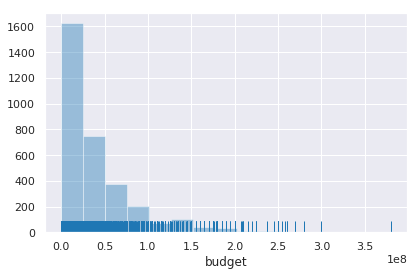

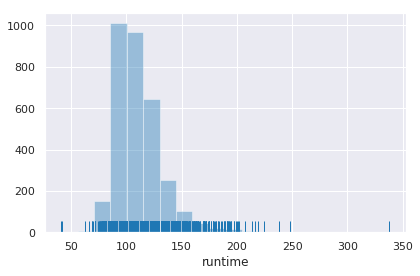

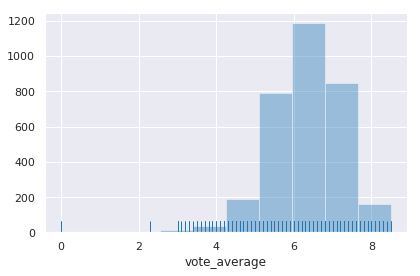

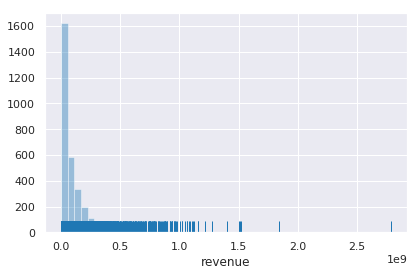

In [0]:
from IPython.display import display

print('DISTRIBUTION PLOTS \n')

sns.distplot(data['budget'], kde=False, rug=True, bins=15)
plt.tight_layout()
plt.show()

sns.distplot(data['runtime'].dropna(), kde=False, rug=True, bins=20)
plt.tight_layout()
plt.show()

sns.distplot(data['vote_average'], kde=False, rug=True, bins=10)
plt.tight_layout()
plt.show()

sns.distplot(data['revenue'], kde=False, rug=True)
plt.tight_layout()
plt.show()

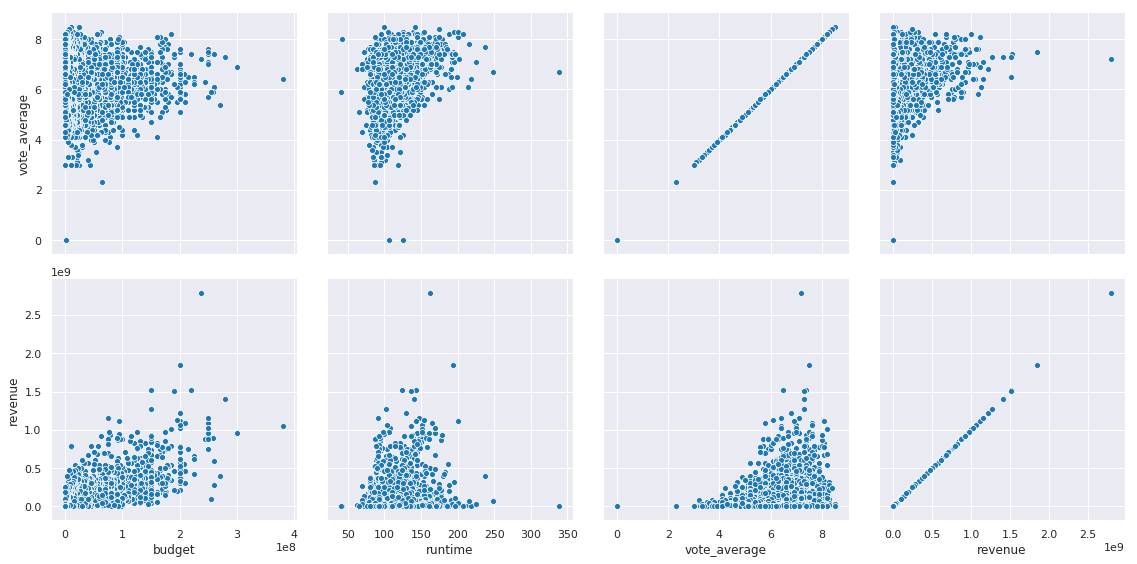

In [0]:
sns.pairplot(data, x_vars=['budget','runtime','vote_average','revenue'], y_vars=['vote_average','revenue'], height=4);

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

# Get ids
def get_ids(cell):
  
  try:
    
    cell_array = eval(cell)
  
  except:
    
    cell_array = []

  if len(cell_array)>0:
    ids_list = [v['id'] for v in cell_array]
    
  else:
    ids_list = []
  
  return ids_list

def get_cast_ids(cell):
  
  try:
    
    cell_array = eval(cell)
  
  except:
    
    cell_array = []

  if len(cell_array) >= 10:
    lim = 10
  else:
    lim = len(cell_array)
    
  ids_list = [cell_array[i]['id'] for i in range(0,lim)]
  
  return ids_list

def get_crew_ids(cell,filter_staff):
  
  try:
    
    cell_array = eval(cell)
  
  except:
    
    cell_array =  [0]
    
  staff_members_ids = [member['id'] for member in cell_array if member['job'] == filter_staff]
    
  return staff_members_ids


# Crate Dataframe with ids
def create_df_ids(ids,column_name):
  
  enc = MultiLabelBinarizer()
  np_ids = enc.fit_transform(ids)
  
  # Save encoder in a pickle
  
  column_names = []
  print('Num classes of '+ column_name + ': ' + str(len(enc.classes_)))
  
  for c in enc.classes_:
    column_names.append(column_name + '_' + str(c))
  
  df_ids = pd.DataFrame(data = np_ids, index=data.index, columns=column_names)
  
  return df_ids


# Merge dataframe ids with data
def merge_ids(data,column_name):
  
  if column_name == 'crew':
    df = data.copy()
  
    staff = ['Producer','Editor','Director','Original Music Composer','Writer','Screenplay']
    for i in staff:

      ids = data['crew'].apply(lambda x: get_crew_ids(x,i))

      df_ids = create_df_ids(ids,i)

      df = df.join(df_ids)
    return df
  
  elif column_name == 'cast':
    ids = data[column_name].apply(lambda x: get_cast_ids(x))
  
  else:
    ids = data[column_name].apply(lambda x: get_ids(x))
    
  df_ids = create_df_ids(ids,column_name)
  
  df = data.copy()
  df = df.join(df_ids)
  
  return df

In [0]:
columns_with_ids = ['genres','production_companies','cast','crew']

for i in columns_with_ids:
  data = merge_ids(data,i)

Num classes of genres: 19
Num classes of production_companies: 3585
Num classes of cast: 13311
Num classes of Producer: 3578
Num classes of Editor: 1241
Num classes of Director: 1599
Num classes of Original Music Composer: 756
Num classes of Writer: 1131
Num classes of Screenplay: 2288


In [0]:
# Original_language
dummies_languages = pd.get_dummies(data['original_language'], drop_first=True)
data = data.join(dummies_languages)

In [0]:
data.shape

(3229, 27547)

In [0]:
data.head(1)

,original_title,budget,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,cast,crew,vote_average,revenue,genres_12,genres_14,genres_16,genres_18,genres_27,genres_28,genres_35,genres_36,genres_37,genres_53,genres_80,genres_99,genres_878,genres_9648,genres_10402,genres_10749,genres_10751,genres_10752,genres_10769,production_companies_1,production_companies_2,production_companies_3,production_companies_4,production_companies_5,production_companies_6,production_companies_7,production_companies_8,...,Screenplay_1493738,Screenplay_1524786,Screenplay_1527481,Screenplay_1527482,Screenplay_1536766,Screenplay_1542277,Screenplay_1560760,Screenplay_1582654,Screenplay_1582866,Screenplay_1601942,Screenplay_1634294,Screenplay_1750058,Screenplay_1777724,Screenplay_1860293,cn,da,de,en,es,fa,fr,he,hi,id,is,it,ja,ko,nb,nl,no,pl,pt,ro,ru,te,th,vi,xx,zh
0,Avatar,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",en,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.2,2787965087,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
data.drop(['spoken_languages','vote_average','genres','original_language','production_companies',
           'production_countries','release_date','cast','crew','revenue'], axis=1).head(3)

,original_title,budget,runtime,genres_12,genres_14,genres_16,genres_18,genres_27,genres_28,genres_35,genres_36,genres_37,genres_53,genres_80,genres_99,genres_878,genres_9648,genres_10402,genres_10749,genres_10751,genres_10752,genres_10769,production_companies_1,production_companies_2,production_companies_3,production_companies_4,production_companies_5,production_companies_6,production_companies_7,production_companies_8,production_companies_9,production_companies_11,production_companies_12,production_companies_13,production_companies_14,production_companies_18,production_companies_23,production_companies_24,production_companies_27,production_companies_28,...,Screenplay_1493738,Screenplay_1524786,Screenplay_1527481,Screenplay_1527482,Screenplay_1536766,Screenplay_1542277,Screenplay_1560760,Screenplay_1582654,Screenplay_1582866,Screenplay_1601942,Screenplay_1634294,Screenplay_1750058,Screenplay_1777724,Screenplay_1860293,cn,da,de,en,es,fa,fr,he,hi,id,is,it,ja,ko,nb,nl,no,pl,pt,ro,ru,te,th,vi,xx,zh
0,Avatar,237000000,162.0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,300000000,169.0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Spectre,245000000,148.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:

x = data.drop(['original_title','spoken_languages','vote_average','genres','original_language','production_companies',
               'production_countries','release_date','cast','crew','revenue'], axis=1).values

y = data['vote_average'].values

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1992)

In [0]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 50,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 1
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=600,
                valid_sets=lgb_eval)


[1]	valid_0's l2: 0.741327	valid_0's l1: 0.657131
[2]	valid_0's l2: 0.737734	valid_0's l1: 0.65547
[3]	valid_0's l2: 0.734731	valid_0's l1: 0.654052
[4]	valid_0's l2: 0.731182	valid_0's l1: 0.652431
[5]	valid_0's l2: 0.727805	valid_0's l1: 0.650885
[6]	valid_0's l2: 0.724868	valid_0's l1: 0.649484
[7]	valid_0's l2: 0.721614	valid_0's l1: 0.647926
[8]	valid_0's l2: 0.718366	valid_0's l1: 0.646377
[9]	valid_0's l2: 0.715592	valid_0's l1: 0.645053
[10]	valid_0's l2: 0.712223	valid_0's l1: 0.643384
[11]	valid_0's l2: 0.708649	valid_0's l1: 0.641678
[12]	valid_0's l2: 0.706632	valid_0's l1: 0.640705
[13]	valid_0's l2: 0.703585	valid_0's l1: 0.639304
[14]	valid_0's l2: 0.700195	valid_0's l1: 0.63764
[15]	valid_0's l2: 0.696943	valid_0's l1: 0.635998
[16]	valid_0's l2: 0.693731	valid_0's l1: 0.634386
[17]	valid_0's l2: 0.690651	valid_0's l1: 0.632788
[18]	valid_0's l2: 0.687586	valid_0's l1: 0.631276
[19]	valid_0's l2: 0.684618	valid_0's l1: 0.629828
[20]	valid_0's l2: 0.681725	valid_0's l1: 

In [0]:
from sklearn.metrics import mean_squared_error

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.7300146376950819


In [0]:
result = {'real': y_test,
         'pred': y_pred}

result = pd.DataFrame(result)

In [0]:
result.head(20)

,real,pred
0,6.9,7.507288
1,7.1,7.037933
2,5.4,5.625468
3,5.3,6.039315
4,6.3,6.212843
5,7.3,7.039850
6,6.5,5.812506
7,5.8,6.028290
8,6.1,6.810110
9,6.7,6.028439


In [0]:
result.describe()

,real,pred
count,646.000000,646.000000
mean,6.311146,6.318330
std,0.863722,0.500599
min,2.300000,4.528587
25%,5.900000,6.009606
50%,6.350000,6.322814
75%,6.900000,6.679490
max,8.300000,7.579947
